By Juliencs
This again uses the same housing data but it is approached from a different perspective

Introduction

This kernel is an attempt to use every trick in the books to unleash the full power of Linear Regression, including a lot of preprocessing and a look at several Regularization algorithms.

At the time of writing, it achieves a score of about 0.121 on the public LB, just using regression, no RF, no xgboost, no ensembling etc. All comments/corrections are more than welcome.

In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


In [123]:
#Definitions
pd.set_option("display.float_format",lambda x:'%.3f'%x)
%matplotlib inline 
# njobs=4

In [124]:
#Get data 
train=pd.read_csv("../Python EDA/train.csv")
print("train:" +str(train.shape))

train:(1460, 81)


In [126]:
print("The number of numerical features that have missing values " + str(train.isnull().values.sum()))

The number of numerical features that have missing values 6965


In [127]:
#Check for duplicates 
idsUnique=len(set(train.Id))
idsTotal=train.shape[0]
idsUnique

1460

In [128]:
idsTotal

1460

In [129]:
idsDupli=idsTotal-idsUnique
print("There are"+ str(idsDupli)+" duplicate ids for" + str(idsTotal)+"total entries")

There are0 duplicate ids for1460total entries


In [130]:
#Drop Id column
train.drop("Id", axis=1,inplace=True)

# Preprocessing


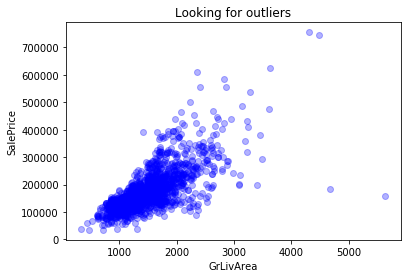

In [131]:
#Looking for outliers
plt.scatter(train.GrLivArea,train.SalePrice,c="blue",alpha=0.3);
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [132]:
#From looking at the plot itself, we can just eyeball the cut off for outliers
train=train[train.GrLivArea<4000]

In [133]:
#Log transform the target for official scoring
train.SalePrice=np.log1p(train.SalePrice)
y=train.SalePrice

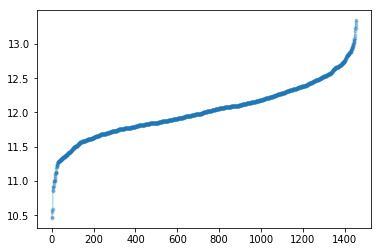

In [134]:
#Looking at the distribution after log transformation
x=np.arange(len(y))
y1=pd.DataFrame(y).sort_values(by="SalePrice")
plt.plot(x,y1,alpha=0.3,marker=".");

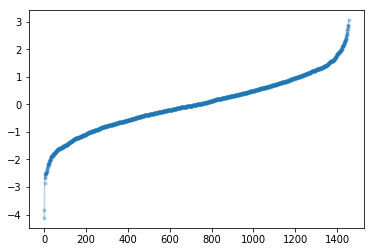

In [135]:
y2=pd.DataFrame(np.random.normal(0,1,len(y)))
y2.columns=["First"]
y2.sort_values(by="First",inplace=True)
plt.plot(x,y2,alpha=0.3,marker='.');
#Comparing the two, we can see that after log transfromation, the Saleprice is indeed normalized

Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally. The following set of activities is to look at all the features and understand the impact of missing value in the context of each dataset and treat them respectively. 

In [136]:
#Handle missing values for features where median/mean or most common value doesn't make sense
#Alley: data description says NA means no alley access
train.loc[:,"Alley"]=train.loc[:,"Alley"].fillna("None")

In [137]:
#BedroomabovgrL NA most likely means 0
train.loc[:,"BedroomAbvGr"]=train.loc[:,"BedroomAbvGr"].fillna(0)

In [138]:
# BsmtQaul etcL data description says that NA for basement features is no basement
train.loc[:,"BsmtQual"]=train.loc[:,"BsmtQual"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)

In [139]:
#Central Air: NA means no
train.loc[:,"CentralAir"]=train.loc[:,"CentralAir"].fillna("No")

In [140]:
#Condition: NA means normal
train.loc[:,"Condition1"]=train.loc[:,"Condition1"].fillna("Norm")
train.loc[:,"Condition2"]=train.loc[:,"Condition2"].fillna("Norm")

In [141]:
#EnclosedPorch: NA means no enclosed porch
train.loc[:,"EnclosedPorch"]=train.loc[:,"EnclosedPorch"].fillna(0)

In [142]:
#External stuff: NA most likely means average
train.loc[:,"ExterCond"]=train.loc[:,"ExterCond"].fillna("TA")
train.loc[:,"ExterQual"]=train.loc[:,"ExterQual"].fillna("TA")


In [143]:
#Fence: data description says NA means no fence
train.loc[:,"Fence"]=train.loc[:,"Fence"].fillna("No")

In [144]:
#FirePlaceQU: data description says that it means no fire place
train.loc[:,"FireplaceQu"]=train.loc[:,"FireplaceQu"].fillna("No")
train.loc[:,"Fireplaces"]=train.loc[:,"Fireplaces"].fillna(0)

In [145]:
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

In [146]:
#some numerical features are actually really categories
#The following is used to replace values by value for specific columns, the 
#structure is set up kind of like a dictionary in replacing each of the values
train=train.replace({"MSSubClass": {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [147]:
#The following encoding categorical features as ordered numbers when the information is in that order
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

New features are created in 3 new ways:
1. Simplifications of existing features 
2. Combinations of existing features 
3. Polynomials on the top 10 existing features 
Do this to make simple features of 3 categories

# Simplifications of existing features

In [148]:
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2 combinations of existing features


In [149]:
#Specifically how the features are combined like this requires a lot of trial and error
# 2* Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [150]:
#Find most important features relative to target
print("Find most import features relative to target")
corr=train.corr()
corr.sort_values(["SalePrice"],ascending=False,inplace=True)
print(corr.SalePrice)

Find most import features relative to target
SalePrice            1.000
OverallQual          0.819
AllSF                0.817
AllFlrsSF            0.729
GrLivArea            0.719
SimplOverallQual     0.708
ExterQual            0.681
GarageCars           0.680
TotalBath            0.673
KitchenQual          0.667
GarageScore          0.657
GarageArea           0.655
TotalBsmtSF          0.642
SimplExterQual       0.636
SimplGarageScore     0.631
BsmtQual             0.615
1stFlrSF             0.614
SimplKitchenQual     0.610
OverallGrade         0.604
SimplBsmtQual        0.594
FullBath             0.591
YearBuilt            0.589
ExterGrade           0.587
YearRemodAdd         0.569
FireplaceQu          0.547
GarageYrBlt          0.544
TotRmsAbvGrd         0.533
SimplOverallGrade    0.527
SimplKitchenScore    0.523
FireplaceScore       0.518
                     ...  
BedroomAbvGr         0.204
AllPorchSF           0.199
LotFrontage          0.174
SimplFunctional      0.137
Functional

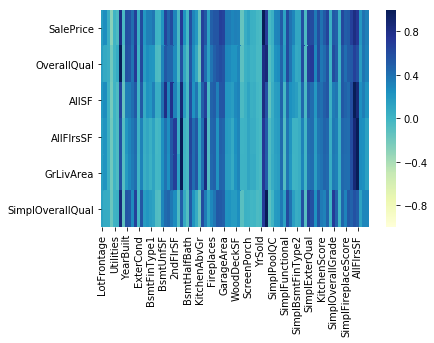

In [151]:
sns.heatmap(corr[(corr["SalePrice"]>0.7 )|(corr["SalePrice"]< -0.7) ],cmap="YlGnBu",vmin=-1,vmax=1)

# Creating new features through increasing the importance of top 10 existing features
This is done through either applying cubed or squared. It is not clear at the time of this writing why this is required

In [152]:
# Create new features
# 3* Polynomials on the top 10 existing features
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

In [153]:
#Differentiate numerical features and categorical features 
#Notice the user of select_dtypes method 
#This method of extracting the columns just by column names
#is also used elsewhere. Gotta take a note of how this is done
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 117
Categorical features : 26


In [157]:
train_num.isnull().values #notice how this transforms the pandas data frameback

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [155]:
#Handling remaining missing values for numerical features by using median as replacement
print("NAs for nuermcial features in train: "+ str(train_num.isnull().values.sum()))

NAs for nuermcial features in train: 155


In [159]:
train_num=train_num.fillna(train_num.median())
print("NAs for nuermcial features in train: "+ str(train_num.isnull().values.sum()))

NAs for nuermcial features in train: 0


In [174]:
#Log transform of the skewed numerical features to lessen impact of outliers 
#As a general rule of thumb a kewness with an absolute value of greater 
# than .5 is considered moderately skewed
skewness=train_num.apply(lambda x:skew(x))
skewness=skewness[abs(skewness)>0.5]
print(str(skewness.shape[0])+" skewed numerical features to log transform")
skewed_features=skewness.index
train_num[skewed_features]=np.log1p(train_num[skewed_features])

53 skewed numerical features to log transform


In [180]:
# Create dummy features for categorical values via one - shot encoding
print("NAs for categorical features in train: "+str(train_cat.isnull().values.sum()))

NAs for categorical features in train: 1


In [182]:
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

Remaining NAs for categorical features in train : 0


# Modelling

In [183]:
# Join categorical and numerical features 
train=pd.concat([train_num,train_cate],axis=1)
print("New Number of features : "+str(train.shape[1]))

New Number of features : 319


In [184]:
#partition the dataset in train _ validation sets
#Using train test split function to quickly achieve that
X_train, X_test, Y_train, Y_test=train_test_split(train,y,test_size=0.3,random_state=0)

In [185]:
print("X_train: "+str(X_train.shape))
print("Y_train: "+str(Y_train.shape))
print("X_test: "+str(X_test.shape))
print("Y_test: "+str(Y_test.shape))


X_train: (1019, 319)
Y_train: (1019,)
X_test: (437, 319)
Y_test: (437,)


In [187]:
# Standardize the numerical features
stdSc=StandardScaler()
X_train.loc[:,numerical_features]=stdSc.fit_transform(X_train.loc[:,numerical_features])
X_test.loc[:,numerical_features]=stdSc.transform(X_test.loc[:,numerical_features])


/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Standardization cannot be done before the partitioning, as we don't want to fite the standard scaler on some observations that will be later used in the test set

In [192]:
#Define error measure for official scoring: RMSE
#Custom function for computing the RMSE score
scorer=make_scorer(mean_squared_error,greater_is_better=False)
def rmse_cv_train(model):
    rmse=np.sqrt(-cross_val_score(model,X_train,Y_train,scoring=scorer,cv=10))
    return(rmse)

def rmse_cv_test(model):
    rmse=np.sqrt(-cross_val_score(model,X_test,Y_test,scoring=scorer,cv=10))
    return(rmse)

http://www.statisticshowto.com/rmse/ (To check out the formula of RMSE)

# 1. linear regression without regularization

In [194]:
#Linear Regression
lr=LinearRegression()
lr.fit(X_train,Y_train);


In [197]:
#Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

RMSE on Training set : 0.265871432546
RMSE on Test set : 21.7981028832


In [198]:
y_train_pred=lr.predict(X_train)
y_test_pred=lr.predict(X_test)

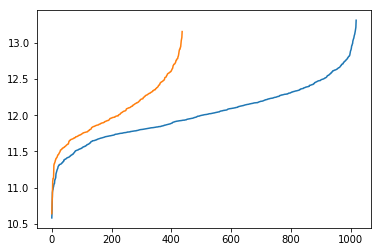

In [203]:
#Sorting numpy array directly instead of using pandas sort values method
plt.plot(np.sort(y_train_pred))
plt.plot(np.sort(y_test_pred));

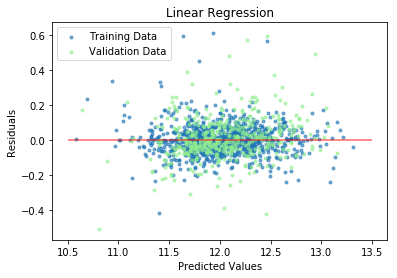

In [211]:
#Plotting the residuals 
plt.scatter(y_train_pred,y_train_pred-Y_train,marker=".",label='Training Data',alpha=0.6)
plt.scatter(y_test_pred,y_test_pred-Y_test,c="lightgreen",marker='.',label="Validation Data",alpha=0.6)
plt.title("Linear Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0,xmin=10.5,xmax=13.5,color="red",alpha=0.6)
plt.show()

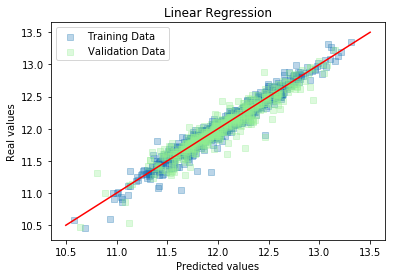

In [214]:
# Plot the predictions
plt.scatter(y_train_pred,Y_train,marker="s",label="Training Data",alpha=0.3)
plt.scatter(y_test_pred,Y_test,marker="s",label="Validation Data",c="lightgreen",alpha=0.3)
plt.title("Linear Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc="upper left")
plt.plot([10.5,13.5],[10.5,13.5],c="red")
plt.show()


#### Key take away from looking at the residual plot
Errors seem randomly distributed and randomly scattered around the centerline, so there is that at least. It means our model was able to capture most of the explanatory information.

# 2 Linear Regression with Ridge regularization (l2 Penalty)

In [217]:
ridge=RidgeCV(alphas=[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, Y_train)
alpha=ridge.alpha_

In [219]:
print("Best alpha:", alpha)

Best alpha: 30.0


In [220]:
print("Try again for more precision with alphas centered around "+ str(alpha))
ridge=RidgeCV(alphas=[alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)

Try again for more precision with alphas centered around 30.0


In [221]:
ridge.fit(X_train,Y_train)
alpha=ridge.alpha_
print("Best alpha : ",alpha)

Best alpha :  24.0


In [224]:
#Looking at RMSE kpi for the performance of the model
print("Ridge RMSE on Training Set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test Set : ", rmse_cv_test(ridge).mean())

Ridge RMSE on Training Set : 0.115710134584
Ridge RMSE on Test Set :  0.117298096616


In [226]:
cross_val_score(ridge,X_train,Y_train,scoring=scorer,cv=10)

array([-0.01273626, -0.02480977, -0.00949909, -0.0184345 , -0.01006183,
       -0.01240288, -0.01958146, -0.00739793, -0.01226715, -0.01105002])

In [227]:
#Ridge prediction results
y_train_rdg=ridge.predict(X_train)
y_test_rdg=ridge.predict(X_test)

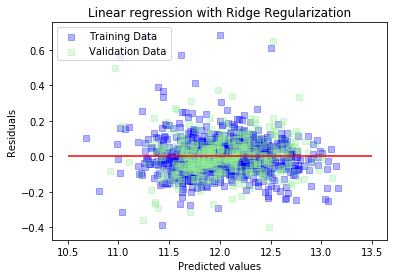

In [230]:
# Plotting 
#label in the function is actually the data set label instead of the plot
#label
plt.scatter(y_train_rdg,y_train_rdg-Y_train,c="blue",marker="s",label="Training Data",alpha=0.3)
plt.scatter(y_test_rdg,y_test_rdg-Y_test,c="lightgreen",marker='s',label="Validation Data",alpha=0.3)
plt.title("Linear regression with Ridge Regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=10.5,xmax=13.5,color="red")
plt.show()


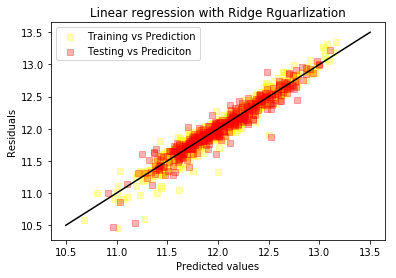

In [236]:
# Plot predictions
plt.scatter(y_train_rdg,Y_train,c="yellow",marker="s",label="Training vs Prediction",alpha=0.3)
plt.scatter(y_test_rdg,Y_test,c='red',marker="s",label="Testing vs Prediciton",alpha=0.3)
plt.title("Linear regression with Ridge Rguarlization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.plot([10.5,13.5],[10.5,13.5],c="black")
plt.show()

In [237]:
#Plot import coefficients
coefs=pd.Series(ridge.coef_,index=X_train.columns)
print("Ridge picked "+str(sum(coefs!=0))+" features and eliminated the other " +\
     str(sum(coefs==0))+ "features")

Ridge picked 316 features and eliminated the other 3features


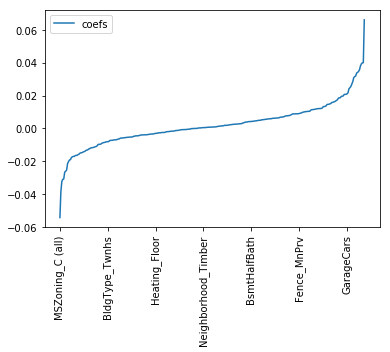

In [280]:
x=list(coefs.index)
y=coefs
test=pd.DataFrame({"coefs":y})
test.sort_values(["coefs"],inplace=True) #how come sorting doesn't impact the order of x getting plotted?
test.plot() #notice how different this becomes when calling plt.plot
plt.xticks(rotation=90);

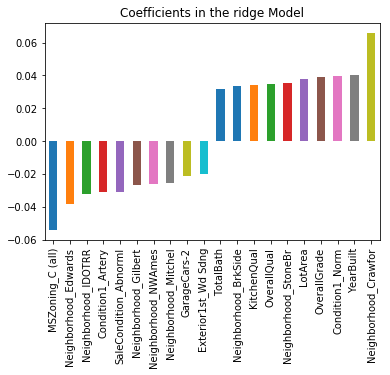

In [276]:
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind="bar")
plt.title("Coefficients in the ridge Model")
plt.show()

We're getting a much better RMSE result now that we've added regularization. The very small difference between training and test results indicate that we eliminated most of the overfitting. Visually, the graphs seem to confirm that idea.

Ridge used almost all of the existing features.

# 3 Linear Regression with Lasso Regularization (l1 Penalty)
LASSO stands for Least Absolute Shrinkage and Selection Operator. It is an alternative regularization method, where we simply replace the square of the weights by the sum of the absolute value of the weights. In contrast to L2 regularization, L1 regularization yields sparse feature vectors : most feature weights will be zero. Sparsity can be useful in practice if we have a high dimensional dataset with many features that are irrelevant.
IT will be more efficient than Ridge

In [283]:
# 3 Lasso 
lasso=LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train,Y_train)
alpha=lasso.alpha_
print("Best alpha:", alpha)

Best alpha: 0.0006


In [284]:
# From the fact how long it takes to execute the command, the function isn't optimized
print("Lasso RMSE on Training set: ", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set:", rmse_cv_test(lasso).mean())
y_train_las=lasso.predict(X_train)
y_test_las=lasso.predict(X_test)

Lasso RMSE on Training set:  0.11425790908
Lasso RMSE on Test set: 0.115016569332


In [291]:
y_train_pred

array([ 12.12027294,  11.8501694 ,  11.68975916, ...,  11.41195294,
        11.98699616,  12.27945352])

In [299]:
train_result=pd.DataFrame({"linear":y_train_pred, "Lasso":y_train_las,"ridge":y_train_rdg})
test_result=pd.DataFrame({"linear":y_test_pred, "Lasso":y_test_las,"ridge":y_test_rdg})
lasso_rmse_train=rmse_cv_train(lasso).mean()
lasso_rmse_test=rmse_cv_test(lasso).mean()
ridge_rmse_train=rmse_cv_train(ridge).mean()
ridge_rmse_test=rmse_cv_test(ridge).mean()
linear_rmse_train=rmse_cv_train(lr).mean()                 
linear_rmse_test=rmse_cv_test(lr).mean()


In [306]:
pd.DataFrame([lasso_rmse_train,
              lasso_rmse_test,
              ridge_rmse_train,
              ridge_rmse_test,
              linear_rmse_train,
              linear_rmse_test])

,0
0,0.114
1,0.115
2,0.116
3,0.117
4,0.266
5,21.798


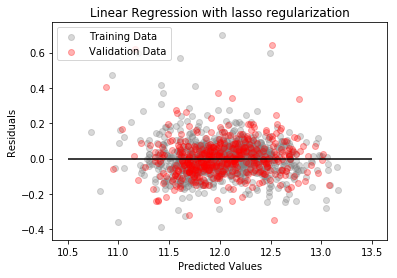

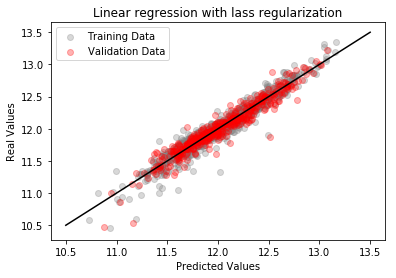

In [302]:
#Plotting the residuals
plt.scatter(y_train_las,y_train_las-Y_train,alpha=0.3,c="gray",label="Training Data")
plt.scatter(y_test_las,y_test_las-Y_test,alpha=0.3,c="red",label="Validation Data")
plt.title("Linear Regression with lasso regularization")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0,xmin=10.5,xmax=13.5,color="black")
plt.show()

#Plotting the predictiions
plt.scatter(y_train_las,Y_train,alpha=0.3,c="gray",label="Training Data")
plt.scatter(y_test_las,Y_test,alpha=.3,c="red",label="Validation Data")
plt.title("Linear regression with lass regularization")
plt.xlabel("Predicted Values")
plt.ylabel("Real Values")
plt.legend(loc="upper left")
plt.plot([10.5,13.5],[10.5,13.5],c="black")
plt.show()


In [307]:
#Plot important coefficients
coefs=pd.Series(lasso.coef_,index=X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")

Lasso picked 112 features and eliminated the other 207 features


In [308]:
imp_coefs=pd.concat([coefs.sort_values().head(10),
                    coefs.sort_values().tail(10)])

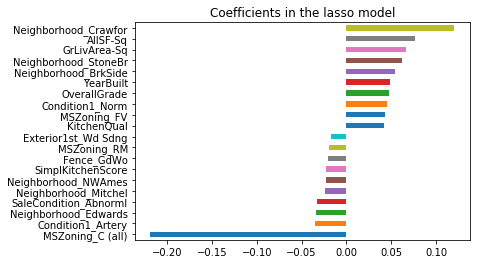

In [309]:
imp_coefs.plot(kind="barh")
plt.title("Coefficients in the lasso model")
plt.show()

RMSE results are better both on training and test sets. The most interesting thing is that Lasso used only one third of the available features. Another interesting tidbit : it seems to give big weights to Neighborhood categories, both in positive and negative ways. Intuitively it makes sense, house prices change a whole lot from one neighborhood to another in the same city.

The "MSZoning_C (all)" feature seems to have a disproportionate impact compared to the others. It is defined as general zoning classification : commercial. It seems a bit weird to me that having your house in a mostly commercial zone would be such a terrible thing.

# 4 Linear Regression with ElasticNet Regularization (l1,l2 penalty)

ElasticNet is a compromise between Ridge and Lasso regression. It has a L1 penalty to generate sparsity and a L2 penalty to overcome some of the limitations of Lasso, such as the number of variables (Lasso can't select more features than it has observations, but it's not the case here anyway).

In [311]:
#4 ElasticNet
elasticNet=ElasticNetCV(l1_ratio= [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train,Y_train)
alpha=elasticNet.alpha_
ratio=elasticNet.l1_ratio_
print("Best l1_ratio:",ratio)
print("Best alpha:",alpha)

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best l1_ratio: 1.0
Best alpha: 0.0006


In [312]:
print("Try again for more precision with l1_ratio centered around " + str(ratio))

Try again for more precision with l1_ratio centered around 1.0


In [ ]:
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train,Y_train)
if(elsticNe.l1_ratio_>1):
    elasticNet.l1_ratio_=1
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )
